<a href="https://colab.research.google.com/github/cclljj/LJ-test/blob/master/4_1_%E6%99%82%E5%BA%8F%E8%B3%87%E6%96%99%E8%99%95%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

時間序列資料是依照時間上發生的先後順序形成的資料，通常在資料上的時間間隔會一樣（例如：五分鐘一筆資料、一小時一筆資料），應用的領域相當廣泛，如：財經、太空工程、訊號處理等，在分析上也有許多統計相關的工具可以使用。
同時也可以發現時序資料是很貼近日常生活的，隨著全球氣候變遷的日益加劇，這幾年全球的平均氣溫越來越高，在夏天時更是讓人熱到非常有感，也越來越難以忍受；又或是在一年中某些季節的空氣品質往往特別差，或者某些地點的空氣品質往往比其他地點來的差等。如果想要更加了解這些生活環境的改變，以及其對應的感測器數值是如何變化的，就會運用到時間序列資料的分析，也就是觀察資料與時間的關係，進而得出結果。本章節將會使用三種資料（空氣品質、水資源、氣象）示範。

章節目標：


*   使用作圖工具觀察時序資料
*   檢測與處理時序資料
*   分解時序資料得到趨勢與週期性



此章節主要使用到的套件有：


1.   kats: 用來分析時序資料的套件，功能包括偵測、預測、特徵擷取等
2.   statsmodels: 統計相關的套件，功能包括統計檢驗、分析、預測
3.   pandas: 以欄列式儲存資料，適合用來載入資料，後續會簡單介紹他的功能
4.   matplotlib: 繪圖相關套件，主要用在資料視覺化

剩下的套件會協助主要套件對資料的處理，功能就不一一做說明，而這些套件在一開始都要先安裝與引入。



# Install Packages

In [ ]:
!pip install --upgrade pip

# Kats
!pip install kats==0.1 ax-platform==0.2.3 statsmodels==0.12.2

# calplot
!pip install calplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Packages

In [ ]:
import warnings
import calplot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.detectors.outlier import OutlierDetector
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData, TimeSeriesIterator
from IPython.core.pylabtools import figsize

#Read Data


首先介紹使用到的工具pandas，pandas是python的程式庫，進行資料分析時常常使用它，也可以把它想成是程式語言中的excel試算表，而pandas的dataframe是二維的資料結構，以行、列儲存資料。
所以一開始，我們先將拿到的資料存入叫作air的dataframe，使用

1.   air.info()會顯示出關於這個dataframe的相關資訊
2.   air.head()會顯示前五筆資料
3.   air.tail()會顯示最後五筆資料

由於是時序資料(time series data)的分析處理，因此每種資料會以一個測站長期以來觀測到的資料來做處理，而dataframe的時間欄位會被設成timestamp這一欄，也會以timestamp作為dataframe的索引(index)

一開始先讀取空氣盒子的資料

## 空品

In [ ]:
air = pd.read_csv("./drive/MyDrive/AS/Time-Series/yunlin-longtime.csv", parse_dates=['timestamp'], index_col="timestamp")
air.info()
air.head()
# df = df[df.index%144==0]
# 資料: https://drive.google.com/file/d/1_LEwGoaoqx65ldUcTeV9jEvaU9PU3YWt/view?usp=sharing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241367 entries, 2022-07-21 00:00:29 to 2021-02-28 23:58:32
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  241367 non-null  int64  
 1   index       241367 non-null  int64  
 2   device_id   241367 non-null  object 
 3   siteName    0 non-null       float64
 4   PM25        241367 non-null  float64
 5   SiteName    232331 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 12.9+ MB


,Unnamed: 0,index,device_id,siteName,PM25,SiteName
timestamp,,,,,,
2022-07-21 00:00:29,0,0,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)
2022-07-21 00:06:30,1,1,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)
2022-07-21 00:12:32,2,2,74DA38C7D2AC,NaN,2.0,雲林縣立平和國小(2017)
2022-07-21 00:18:33,3,3,74DA38C7D2AC,NaN,2.0,雲林縣立平和國小(2017)
2022-07-21 00:24:34,4,4,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)


我們想觀察的資訊為時間與PM2.5數值的關係，因此先刪掉其他不需要用到的欄位(column)，也就是 'Unnamed: 0', 'device_id', 'siteName', 'SiteName' 這幾個欄位，並將資料以時間排序

In [ ]:
air.drop(columns=['Unnamed: 0', 'index', 'device_id', 'siteName', 'SiteName'], inplace=True)
air.sort_values(by='timestamp', inplace=True)
# df.set_index('timestamp', inplace=True)
air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241367 entries, 2018-08-01 00:00:05 to 2022-07-31 23:56:21
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PM25    241367 non-null  float64
dtypes: float64(1)
memory usage: 3.7 MB


## 水

接著讀取水位資料，也是重複上述的操作

In [ ]:
water = pd.read_csv("./drive/MyDrive/AS/Time-Series/water1.csv", parse_dates=['timestamp'], index_col="timestamp")
water.info()
water.head()
# 資料: https://drive.google.com/file/d/146C4QiGrtJDm3uLEWTV99ZC6QCg3LVzF/view?usp=sharing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7216 entries, 2021-12-05 00:00:00 to 2021-02-22 23:00:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          7216 non-null   int64  
 1   station_id          7216 non-null   object 
 2   ciOrgname           7216 non-null   object 
 3   ciCategory          7216 non-null   object 
 4   Organize_Name       7216 non-null   object 
 5   CategoryInfos_Name  7216 non-null   object 
 6   PQ_name             7216 non-null   object 
 7   PQ_fullname         7216 non-null   object 
 8   PQ_description      7216 non-null   object 
 9   PQ_unit             7216 non-null   object 
 10  value               7216 non-null   float64
 11  PQ_id               7216 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 732.9+ KB


,Unnamed: 0,station_id,ciOrgname,ciCategory,Organize_Name,CategoryInfos_Name,PQ_name,PQ_fullname,PQ_description,PQ_unit,value,PQ_id
timestamp,,,,,,,,,,,,
2021-12-05 00:00:00,0,338c9c1c-57d8-41d7-9af2-731fb86e632c,水利署,河川水位站,經濟部水利署水文技術組,水文,水位,建國橋.水位,現場觀測,m,49.08,0024c5d8-0471-49db-bf26-78d0cd0fa3b3
2021-12-05 01:00:00,1,338c9c1c-57d8-41d7-9af2-731fb86e632c,水利署,河川水位站,經濟部水利署水文技術組,水文,水位,建國橋.水位,現場觀測,m,49.08,0024c5d8-0471-49db-bf26-78d0cd0fa3b3
2021-12-05 02:00:00,2,338c9c1c-57d8-41d7-9af2-731fb86e632c,水利署,河川水位站,經濟部水利署水文技術組,水文,水位,建國橋.水位,現場觀測,m,49.08,0024c5d8-0471-49db-bf26-78d0cd0fa3b3
2021-12-05 03:00:00,3,338c9c1c-57d8-41d7-9af2-731fb86e632c,水利署,河川水位站,經濟部水利署水文技術組,水文,水位,建國橋.水位,現場觀測,m,49.08,0024c5d8-0471-49db-bf26-78d0cd0fa3b3
2021-12-05 04:00:00,4,338c9c1c-57d8-41d7-9af2-731fb86e632c,水利署,河川水位站,經濟部水利署水文技術組,水文,水位,建國橋.水位,現場觀測,m,49.08,0024c5d8-0471-49db-bf26-78d0cd0fa3b3


同樣地也將不需要的column刪除，留下時間資訊與水位高度的數值，並將資料以時間排序

In [ ]:
water.drop(columns=['Unnamed: 0', 'station_id', 'ciOrgname', 'ciCategory', 'Organize_Name', 'CategoryInfos_Name', 'PQ_name', 'PQ_fullname', 'PQ_description', 'PQ_unit', 'PQ_id'], inplace=True)
water.sort_values(by='timestamp', inplace=True)
water.info()
water.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7216 entries, 2021-01-01 00:00:00 to 2021-12-07 11:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   7216 non-null   float64
dtypes: float64(1)
memory usage: 112.8 KB


,value
timestamp,
2021-01-01 00:00:00,49.10
2021-01-01 01:00:00,49.09
2021-01-01 02:00:00,49.10
2021-01-01 03:00:00,49.10
2021-01-01 04:00:00,49.10


## 氣象

氣象資料的讀取資料方法一樣與上面相同

In [ ]:
climate = pd.read_csv("./drive/MyDrive/AS/Time-Series/climate1.csv", parse_dates=['obsTime'], index_col="obsTime")
climate.info()
climate.head()
# 資料: https://drive.google.com/file/d/1sUZpgygM-bGlejBCstbEC5idcTjdelVR/view?usp=sharing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8823 entries, 2021-12-16 00:00:00 to 2021-02-04 23:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8823 non-null   int64  
 1   station_id  8823 non-null   object 
 2   ELEV        8823 non-null   float64
 3   WDIR        8821 non-null   float64
 4   WDSD        8821 non-null   float64
 5   TEMP        8823 non-null   float64
 6   HUMD        8821 non-null   float64
 7   PRES        8823 non-null   float64
 8   SUN         7321 non-null   float64
 9   H_24R       8821 non-null   float64
 10  H_FX        8821 non-null   float64
 11  H_XD        8821 non-null   object 
 12  H_FXT       8810 non-null   float64
 13  D_TX        8806 non-null   object 
 14  D_TXT       7321 non-null   float64
 15  D_TN        8806 non-null   object 
 16  D_TNT       0 non-null      float64
dtypes: float64(12), int64(1), object(4)
memory usage: 1.2+ MB


,Unnamed: 0,station_id,ELEV,WDIR,WDSD,TEMP,HUMD,PRES,SUN,H_24R,H_FX,H_XD,H_FXT,D_TX,D_TXT,D_TN,D_TNT
obsTime,,,,,,,,,,,,,,,,,
2021-12-16 00:00:00,0,C0F970,145.0,111.0,1.0,19.7,0.89,999.4,0.0,-99.0,-99.0,-99,27.3,2021-12-15 13:40:00,16.3,2021-12-15 06:50:00,NaN
2021-12-16 01:00:00,1,C0F970,145.0,112.0,0.7,19.5,0.90,999.5,0.0,-99.0,-99.0,-99,19.7,2021-12-16 00:10:00,19.5,2021-12-16 01:00:00,NaN
2021-12-16 02:00:00,2,C0F970,145.0,0.0,0.0,19.6,0.90,999.5,0.0,-99.0,-99.0,-99,19.7,2021-12-16 01:40:00,19.4,2021-12-16 01:20:00,NaN
2021-12-16 03:00:00,3,C0F970,145.0,112.0,0.8,19.5,0.90,999.2,0.0,-99.0,-99.0,-99,19.7,2021-12-16 01:40:00,19.4,2021-12-16 01:20:00,NaN
2021-12-16 04:00:00,4,C0F970,145.0,0.0,0.1,19.4,0.91,999.2,0.0,-99.0,-99.0,-99,19.7,2021-12-16 01:40:00,19.2,2021-12-16 03:30:00,NaN


In [ ]:
climate.drop(columns=['Unnamed: 0'], inplace=True)
climate.sort_values(by='obsTime', inplace=True)
climate.info()
climate.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8823 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  8823 non-null   object 
 1   ELEV        8823 non-null   float64
 2   WDIR        8821 non-null   float64
 3   WDSD        8821 non-null   float64
 4   TEMP        8823 non-null   float64
 5   HUMD        8821 non-null   float64
 6   PRES        8823 non-null   float64
 7   SUN         7321 non-null   float64
 8   H_24R       8821 non-null   float64
 9   H_FX        8821 non-null   float64
 10  H_XD        8821 non-null   object 
 11  H_FXT       8810 non-null   float64
 12  D_TX        8806 non-null   object 
 13  D_TXT       7321 non-null   float64
 14  D_TN        8806 non-null   object 
 15  D_TNT       0 non-null      float64
dtypes: float64(12), object(4)
memory usage: 1.1+ MB


,station_id,ELEV,WDIR,WDSD,TEMP,HUMD,PRES,SUN,H_24R,H_FX,H_XD,H_FXT,D_TX,D_TXT,D_TN,D_TNT
obsTime,,,,,,,,,,,,,,,,
2021-01-01,C0F970,145.0,99.0,0.5,10.0,0.66,1006.7,NaN,0.0,-99.0,-99.0,-99.0,10.7,NaN,8.7,NaN
2021-01-01,C0F970,145.0,99.0,0.5,10.0,0.66,1006.7,NaN,0.0,-99.0,-99.0,-99.0,10.7,NaN,8.7,NaN
2021-01-01,C0F970,145.0,99.0,0.5,10.0,0.66,1006.7,NaN,0.0,-99.0,-99.0,-99.0,10.7,NaN,8.7,NaN
2021-01-01,C0F970,145.0,99.0,0.5,10.0,0.66,1006.7,NaN,0.0,-99.0,-99.0,-99.0,10.7,NaN,8.7,NaN
2021-01-01,C0F970,145.0,99.0,0.5,10.0,0.66,1006.7,NaN,0.0,-99.0,-99.0,-99.0,10.7,NaN,8.7,NaN


到這邊我們已經成功讀入資料，現在有三個dataframe，分邊是叫作air(空品資料)、water(水資源資料)、climate(氣象資料)。

以下主要會以空品資料做示範，而大家也可以試著用水資源資料、氣象資料自己試試看

# 資料視覺化(Visualization)

以上的步驟已經完成了初步的拿取資料，現在如果把df這個dataframe印出來看就會看到按照時間排列一筆一筆的資料，但我們可能想看到整體資料的變化，這時將一筆一筆的資料做成折線圖會是一個好的呈現方式

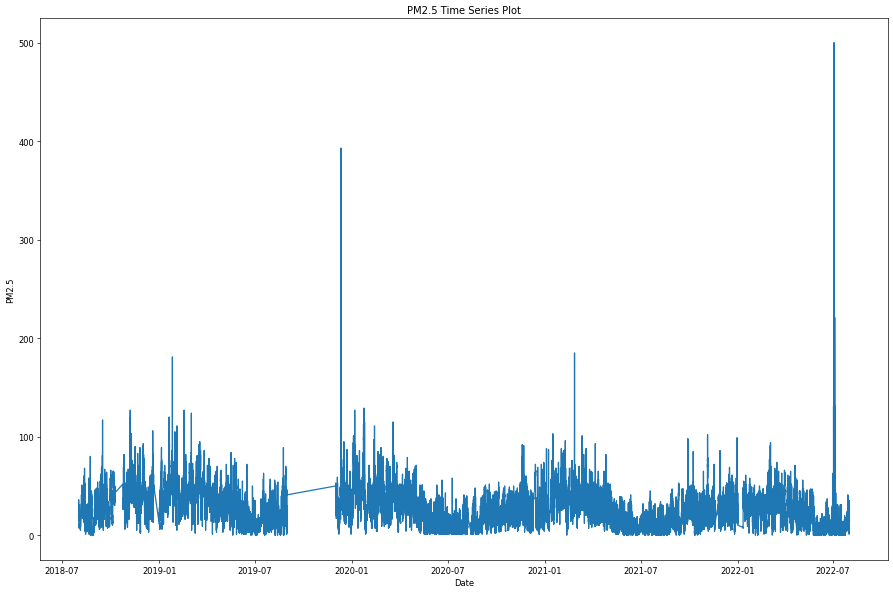

In [ ]:
plt.figure(figsize=(15, 10), dpi=60)
plt.plot(air[:]["PM25"])

plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("PM2.5 Time Series Plot")

plt.tight_layout()

plt.show()

上面這張圖就是從最原始的資料作圖而成，可以看到其實資料是很密集的，變化也很大，這是因為目前的資料是約五分鐘一筆，所以會起伏不定，作出來的圖就像鋸齒狀一般，對我們來說過於瑣碎，而且這些資料出現的頻率並不是精確的五分鐘一筆，可能受到各種因素的影響(傳輸速度、機器內部時鐘)，所以我們會重新採樣(resample)，將固定時間內的資料平均起來，這樣的波動幅度不會這麼大，且資料有固定的頻率

In [ ]:
air_hour = air.resample('H').mean()
air_day = air.resample('D').mean()
air_month = air.resample('M').mean()

print(air_hour.head())
print(air_day.head())
print(air_month.head())

                          PM25
timestamp                     
2018-08-01 00:00:00  18.500000
2018-08-01 01:00:00  20.750000
2018-08-01 02:00:00  24.000000
2018-08-01 03:00:00  27.800000
2018-08-01 04:00:00  22.833333
                 PM25
timestamp            
2018-08-01  23.384615
2018-08-02  13.444444
2018-08-03  14.677419
2018-08-04  14.408451
2018-08-05        NaN
                 PM25
timestamp            
2018-08-31  21.704456
2018-09-30  31.797806
2018-10-31  37.217788
2018-11-30  43.228939
2018-12-31  36.131336


以上步驟就是重新抽樣(resample)，也就是改變資料點出現的頻率，這邊分別是取一小時的平均(air_hour)、一天平均(air_day)、一個月平均(air_month)

以每一小時平均(air_hour)的資料再次作圖，可以看到線條曲線似乎清晰了一點，但波動還是很大。

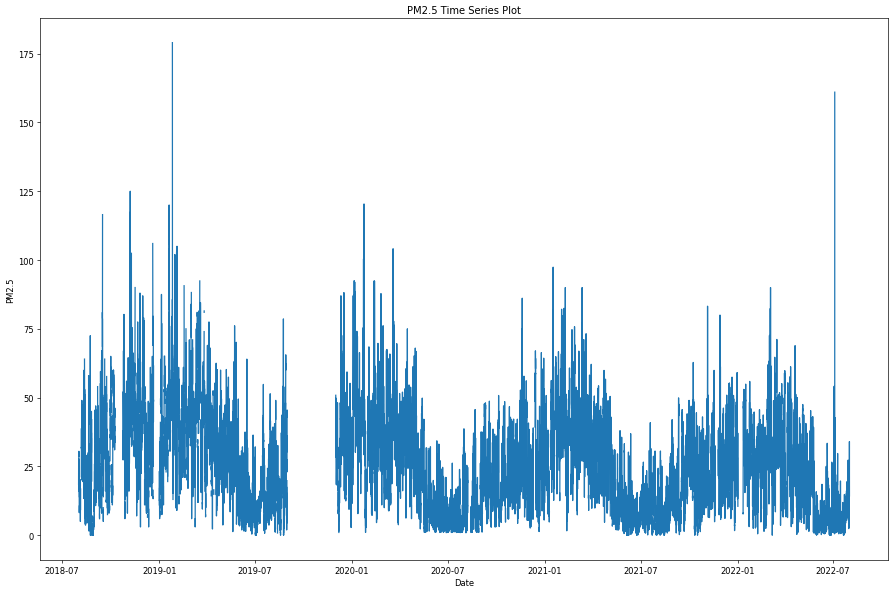

In [ ]:
plt.figure(figsize=(15, 10), dpi=60)
plt.plot(air_hour[:]["PM25"])

plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("PM2.5 Time Series Plot")

plt.tight_layout()

plt.show()

如果想看到整體趨勢的話可以試試看移動平均(moving average)，其中最重要的觀念就是將一部分的資料取平均，至於是哪一部分的資料就要看取樣窗(window)的大小，取樣窗決定要拿自己這筆資料以及自己以前的幾筆資料做平均，舉例來說window=10的時候就是拿自己這筆資料還有自己之前的九筆資料做平均，經過這樣的處理後每筆資料所代表的意義就不只是某一個時間點，而是原本時間點加上前幾個時間點的平均，如此一來，可以消除突發的變化讓作圖的曲線更加圓滑，更容易觀察整體趨勢。

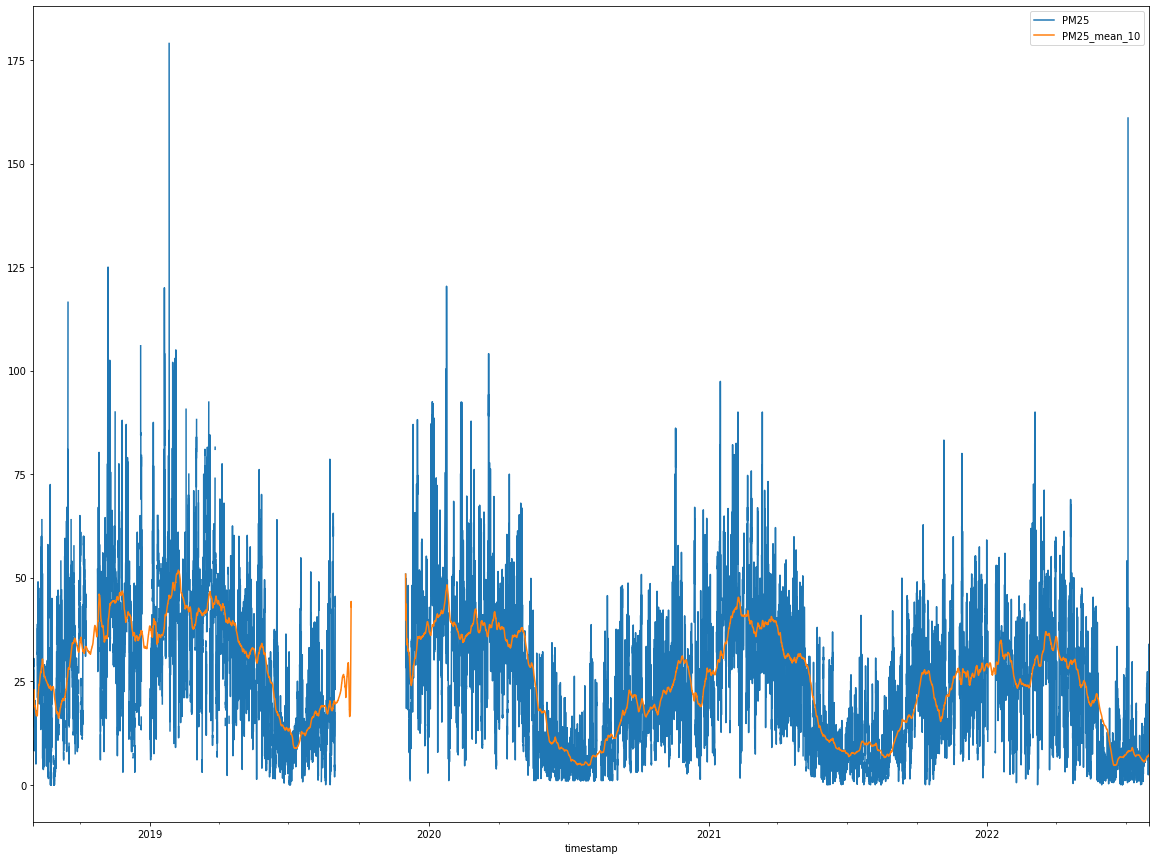

In [ ]:
# plt.figure(figsize=(15, 10), dpi=60)
MA = air_hour
MA10 = MA.rolling(window=500, min_periods=1).mean()

MA.join(MA10.add_suffix('_mean_500')).plot(figsize=(20, 15))
# MA10.plot(figsize(15, 10))

圖中藍色的線是原資料，而橘色的線就是經過移動平均(moving average)後的資料，觀察後可以發現橘色線有某種起伏的規律。

comment <!-- 接著，可以作圖看看資料長什麼樣子，先選擇想要觀察的時間區間，由於part1會觀察一週PM2.5的變化，所以選擇的時間區間為7天，並重設index，這時可以看到資料包含了timestamp和value，我們將會用這兩個數值來作圖 -->

In [ ]:
# cmonth = df_water.loc['2021-11-01':'2021-11-07']
# cmonth.ffill(inplace=True)
# cmonth.reset_index(inplace=True)
# cmonth

剛剛都是直接把原始資料直接作圖來看，已經有看出一些規律，那現在可以試試看不同的方法：

## Part1

(1) 將一年份的資料畫成一條線：
擷取出每筆資料是哪一年，以及它是一年中的第幾個月，藉著這兩種資訊，可以將每一年的一月到十二月各畫出一條線代表PM2.5數值的變化
因為我們的資料的包括的時間範圍有四年，所以會畫出四條線，但因為2019年的資料有缺失、2022年還沒過完，所以這兩條線較短，不過總體來看這四條線隨著月份而改變的趨勢差不多，都是六、七月之前數值降低，六、七月之後數值升高，這也很符合之前作圖看到的規律


                     level_0   index  PM25  year month
timestamp                                             
2018-08-01 00:00:05        0  154941  20.0  2018   Aug
2018-08-01 00:30:18        1  154942  17.0  2018   Aug
2018-08-01 01:12:34        2  154943  18.0  2018   Aug
2018-08-01 01:18:36        3  154944  21.0  2018   Aug
2018-08-01 01:30:44        4  154945  22.0  2018   Aug
...                      ...     ...   ...   ...   ...
2022-07-31 23:32:12   241362    3078  15.0  2022   Jul
2022-07-31 23:38:14   241363    3079  15.0  2022   Jul
2022-07-31 23:44:16   241364    3080  15.0  2022   Jul
2022-07-31 23:50:18   241365    3081  15.0  2022   Jul
2022-07-31 23:56:21   241366    3082  15.0  2022   Jul

[241367 rows x 5 columns]


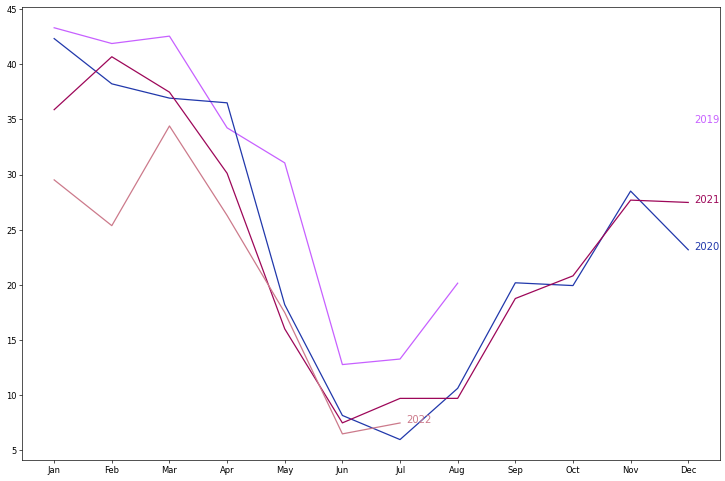

In [ ]:
air_month.reset_index(inplace=True)
air_month['year'] = [d.year for d in air_month.timestamp]
air_month['month'] = [d.strftime('%b') for d in air_month.timestamp]
years = air_month['year'].unique()
print(air)

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(15, 10), dpi=60)
for i, y in enumerate(years):
  if i > 0:
    plt.plot('month', 'PM25', data=air_month.loc[air_month.year==y, :], color=mycolors[i], label=y)
    plt.text(air_month.loc[air_month.year==y, :].shape[0]-.9, air_month.loc[air_month.year==y, 'PM25'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='PM25', xlabel='Month')
# plt.yticks(fontsize=12, alpha=.7)
# plt.title('Seasonal Plot of PM25 Time Series', fontsize=20)
plt.show()

## Part2

comment <!-- 第二部分則是先擷取出每筆資料是星期幾，再去畫出星期一到星期日各別的箱形圖，呈現資料的四分位數，以及最大最小值 -->

In [ ]:
# cmonth['day'] = [d.strftime('%d') for d in cmonth.timestamp]
# days = cmonth['day'].unique()
# print(days)
# # fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
# sns.boxplot(x='day', y='value', data=cmonth)

(2) 用日曆圖(calendar map)看出每天的數值：
我們使用calplot這個套件，只要將每天的PM2.5平均數值輸入後，再選擇顏色就可以得到下圖，可以看到接近藍色的數值比較高，接近綠色的數值比較低，如果沒顏色或是數值是0則代表沒有那一天的資料，而在圖中只要是中間的月份顏色就比較淡，也很符合我們之前觀察到的結果


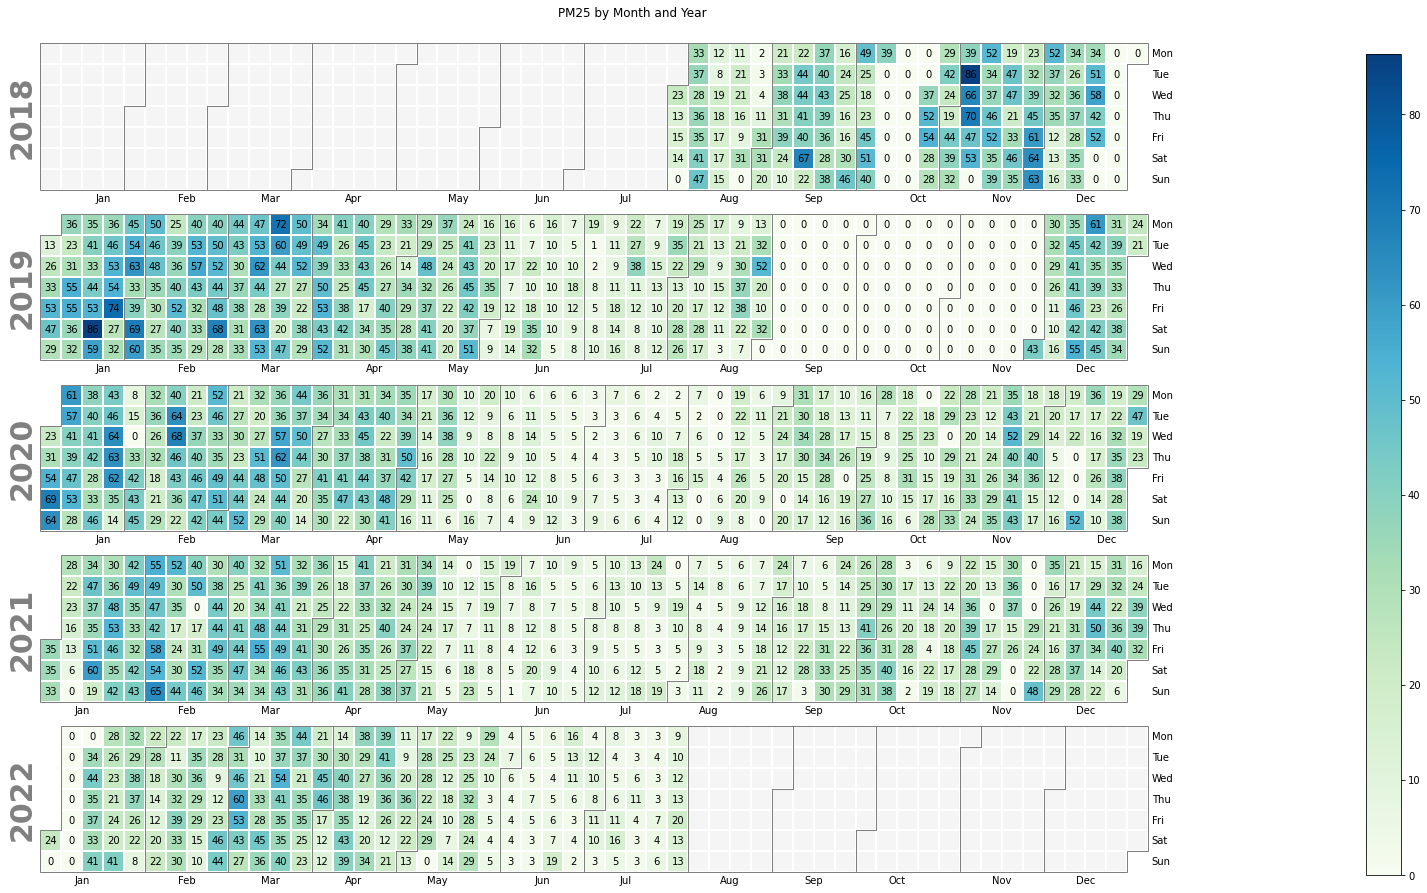

In [ ]:
pl1 = calplot.calplot(data = air_day['PM25'], cmap = 'GnBu', textformat = '{:.0f}', figsize = (24, 12), suptitle = "PM25 by Month and Year")

# 資料品質檢測與處理

接下來這一部分會用到kats套件，這個套件提供一些已經開發好的工具讓我們來檢測資料品質

## Outlier detection

(1) 離群值(outlier)偵測：離群值指的是資料中某些數據點與其他數據點有顯著差異，這些差異可能會影響我們對資料的分析結果，因此會想將離群值找出來並刪除。

我們先把原本dataframe的資料格式轉成kats這個套件用的TimeSeriesData格式，並將這些資料取名叫做air_ts

接著將PM2.5與時間的關係作圖

再來使用異常偵測的工具偵測離群值

In [ ]:
# air_hour.drop(columns=['index'], inplace=True)

<class 'kats.consts.TimeSeriesData'>


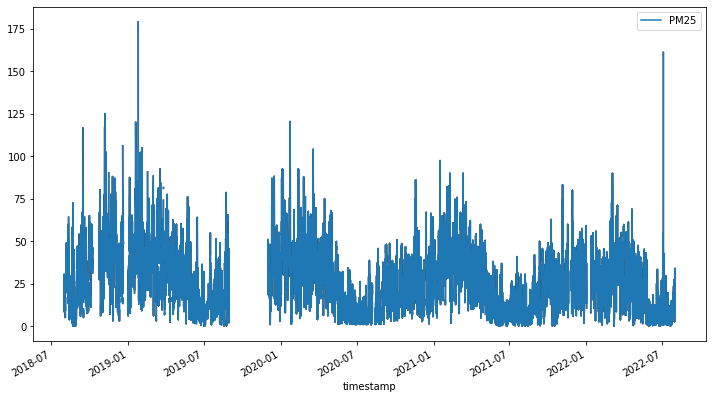

In [ ]:
air_ts = TimeSeriesData(air_hour.reset_index(), time_col_name='timestamp')
print(type(air_ts))
air_ts.plot(cols=["PM25"])
outlierDetection = OutlierDetector(air_ts, 'additive')
outlierDetection.detector()


可以看到以下時間的數據被判斷為outlier data

In [ ]:
outlierDetection.outliers  #7/28-8/3

把離群值移除後再次作圖，可以看到像是2022-07有一個異常的高峰就被移除了。

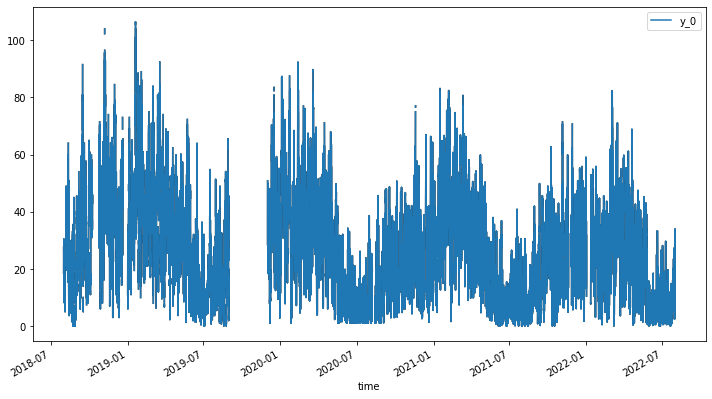

In [ ]:
# outlier_range1 = outlierDetection.outliers[0]
# outlier_range1
outliers_removed = outlierDetection.remover(interpolate=False)
outliers_removed
outliers_removed.plot(cols=['y_0'])

## Change point

改變點(change point)偵測：改變點是資料中突然發生的改變，代表的是資料狀態的轉變或是資料分布的轉變，找出改變點也對資料的分析、預測很有幫助。

這邊根據資料的平均值是否變化來偵測改變點，同樣也是使用TimeSeriesData的資料格式來儲存時序資料(time series data)，而這邊的detector為CUSUMDetector，會用來偵測平均值的增加或減少。

偵測結果會列出改變點的起始時間與結束時間，也可以作圖，圖中紅色線出現的時間點即為改變點

In [ ]:
# air_day.drop(columns=['index'], inplace=True)

可以看到這邊並沒有偵測到改變點，就肉眼來看的話資料也沒有在某個時間點突然轉變


[]


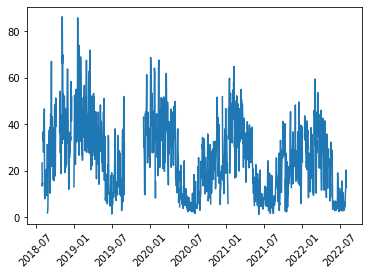

In [ ]:
air_ts = TimeSeriesData(air_day.reset_index(), time_col_name='timestamp')
detector = CUSUMDetector(air_ts)

change_points = detector.detector(change_directions=["increase", "decrease"])
# print("The change point is on", change_points[0][0].start_time)
print(change_points)

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

## Missing data

(3) 缺失資料(missing data)的處理：經過上面的處理後我們可能刪除了一些資料點，或是資料本身的缺失造成某些時間點的資料不存在，但我們又希望資料有固定的頻率，例如：一小時一筆資料、一天一筆資料，所以這邊提供三個方法處理那些缺失的資料：

(a) 將該筆資料表示為Nan(Not a number)：Nan是非數，用來表示未定義或不可表示的值，如果在後續的分析會額外處理這些Nan，則可採用此方法，又可維護資料的真實性

(b) 採用forward fill：如果Nan對後續的資料分析有困難，需要將缺失的值填補起來，最簡單的方法就是forward fill，就是用缺失值的前一個數值來填補

(c) 採用KNN：KNN是K Nearest Neighbor，是找距離缺失值最近的k個數值做平均，用來填補缺失值



In [ ]:
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

# df['knn_mean'] = knn_mean(df.value.values, 8)

In [ ]:
# Nan

# forward fill
df_ffill = air.ffill(inplace=False)

# KNN
df_knn = df.copy()
df_knn['PM25'] = knn_mean(air.PM25.to_numpy(), 5000)

# 資料分解(Decomposition)

經過前面對資料處理的步驟後，有看到資料所呈現的趨勢，但可能不夠清楚、明顯，因此我們要用新的方法-資料分解(decomposition)來對資料進行分析，也就是將資料拆解成趨勢(trend)、週期性(seasonal)、殘差(residual)。。

這邊也是直接使用現成的套件，唯一會碰到的問題就是資料數據點不可為Nan，因此就可以用到上述的方法填補資料。

先將空品每日平均的資料複製一份後，採用forward fill進行缺失資料的處理

In [ ]:
air_process = air_day.copy()
# new.round(1).head(12)
air_process.ffill(inplace=True)

接著我們把尚未進行資料分解的原始資料直接用圖表的方式呈現。

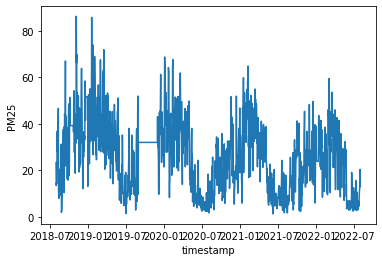

In [ ]:
sns.lineplot(data=air_process, x='timestamp', y='PM25')

最後我們使用seasonal_decompose對資料進行分解，其中需要設定一個 period 參數，指的是資料被拆解的週期，我們先設定為 30天，並於執行後依序產出四張圖：原始資料、趨勢圖、週期性圖與殘差圖。


在週期性圖 (Seasonal) 中，我們可以發現資料在每個週期 (30天) 內有固定的週期變化，而在趨勢圖 (trend)中，我們也可以發現與原始資料的圖表有著十分雷同的特性，在一月附近的數值較高，七月附近的數值則較低。

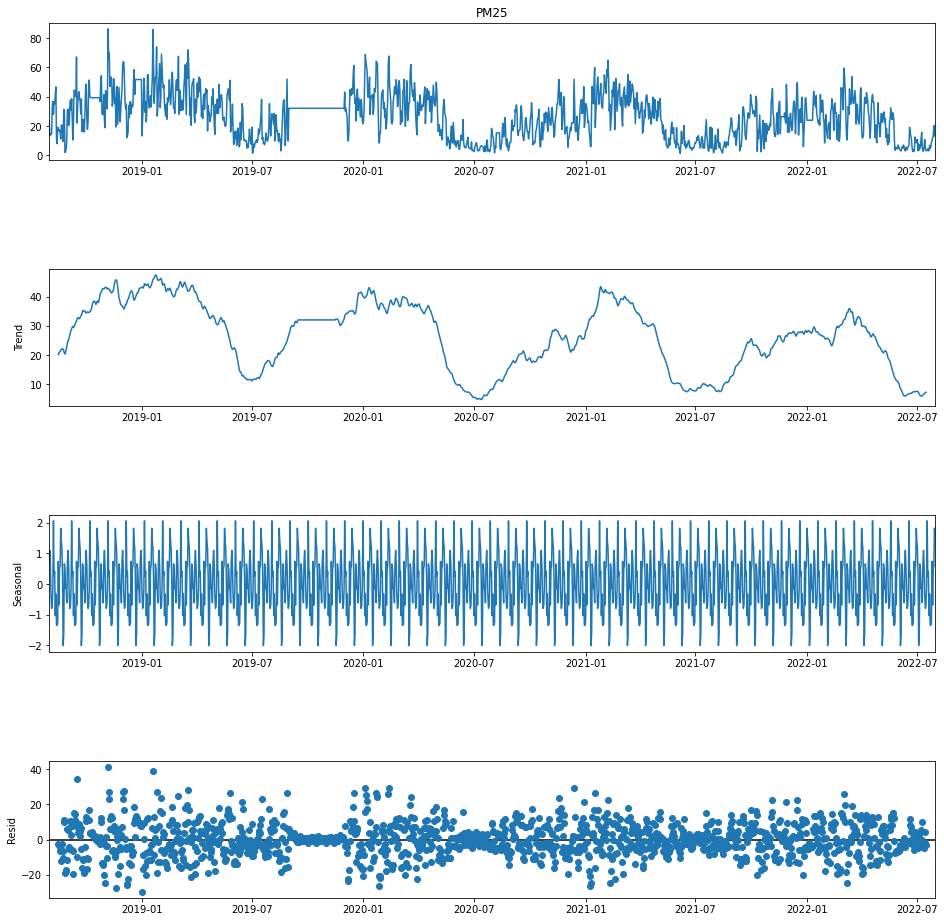

In [ ]:
decompose = seasonal_decompose(air_process['PM25'],model='additive', period=30)
decompose.plot().set_size_inches((15, 15))
plt.show()

接著我們改用較大的尺度來進行分解，將週期改設為 365天 (period=365)，這時候週期性圖 (Seasonal) 中可以觀察一月附近數值較高，而七月附近數值較低的趨勢，而且這個趨勢變化是規律地週期性發生的；而在趨勢圖 (trend)中則可以看到整體緩降的趨勢，也就是說PM2.5的濃度在大趨勢下是越來越低的，從這邊也可以理解到為什麼之前沒找到change point，因為這個趨勢變化是平順的遞減，沒有發生突如其來的變化。

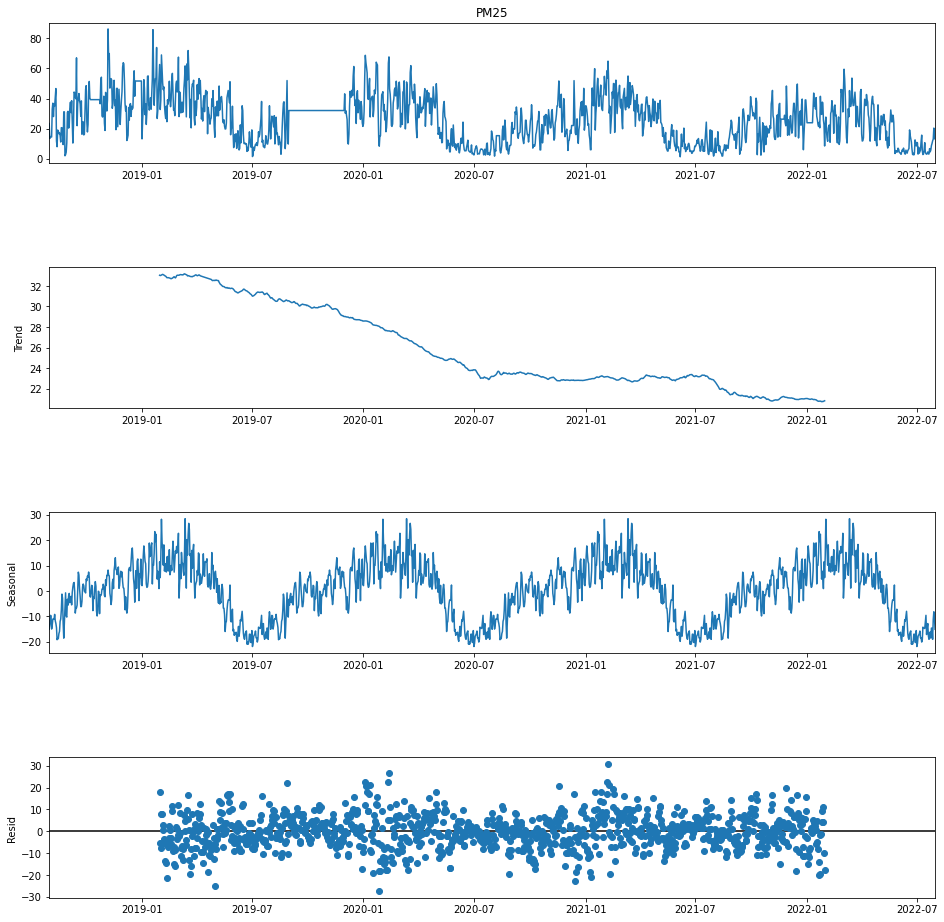

In [ ]:
decompose = seasonal_decompose(air_process['PM25'],model='additive', period=365)
decompose.plot().set_size_inches((15, 15))
plt.show()

----------------------------------------------分隔線----------------------------------------------

# 以下省略

## GET data

In [ ]:
import requests

r = requests.get('https://data.lass-net.org/data/history.php?device_id=08BEAC028630&format=CSV')
# print(r.content)


SSLError: ignored

In [ ]:
print(r.text[10])

IndexError: ignored

## Test for Stationary

先來看看下面兩張圖，我們分別對空品資料、氣溫資料作圖，圖上也三條線，分別代表著平均、變異數、資料本身的數值，我們藉此來觀察這三個數值與時間的關係

In [ ]:
df_D = df.resample('D').mean()
df_D.ffill(inplace=True)

In [ ]:
df_D

,PM25
timestamp,
2021-01-02,14.774390
2021-01-03,10.160000
2021-01-04,10.340000
2021-01-05,10.783133
2021-01-06,18.266932
...,...
2021-12-26,4.067729
2021-12-27,10.425101
2021-12-28,9.435798


從空品資料這張圖中可以看出平均隨時間的變化不大，而變異數一開始變化大，但與時間的關係也不明顯

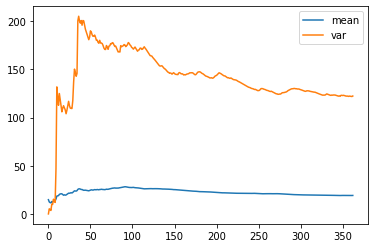

In [ ]:
# df = df['2021-12-02':]

nmp = df_D.PM25.to_numpy()
# nmp = np.log10(nmp)
size = np.size(nmp)

nmp_mean = np.zeros(size)
nmp_var = np.zeros(size)
for i in range(size):
  nmp_mean[i] = nmp[:i+1].mean()
  nmp_var[i] = nmp[:i+1].var()

y1 = nmp_mean[:]
y2 = nmp_var[:]
y3 = nmp
x = np.arange(size)
plt.plot(x, y1, label='mean')
plt.plot(x, y2, label='var')
# plt.plot(x, y3, label='data')
plt.legend()
plt.show()

In [ ]:
df_climate_D = df_climate.resample('D').mean()
df_climate_D.ffill(inplace=True)
df_climate_D.TEMP

obsTime
2021-01-01    12.750000
2021-01-02    14.904348
2021-01-03    16.162500
2021-01-04    17.479021
2021-01-05    17.739130
                ...    
2021-12-27    13.636364
2021-12-28    16.520833
2021-12-29    17.950000
2021-12-30    17.325000
2021-12-31    16.041667
Freq: D, Name: TEMP, Length: 365, dtype: float64

而從溫度資料這張圖來看，可看出平均與變異數均是隨時間遞增而有先遞增後遞減的趨勢。

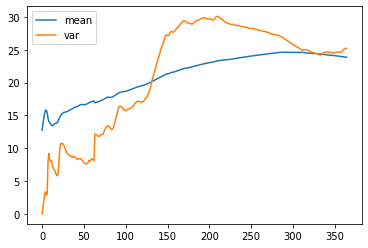

In [ ]:
# df = df['2021-12-02':]
nmp_climate = df_climate_D.TEMP.to_numpy()
# nmp = np.log10(nmp)
size_climate = np.size(nmp_climate)

nmp_climate_mean = np.zeros(size_climate)
nmp_climate_var = np.zeros(size_climate)
for i in range(size_climate):
  nmp_climate_mean[i] = nmp_climate[:i+1].mean()
  nmp_climate_var[i] = nmp_climate[:i+1].var()

y1_climate = nmp_climate_mean[:]
y2_climate = nmp_climate_var[:]
y3_climate = nmp_climate
x_climate = np.arange(size_climate)
plt.plot(x_climate, y1_climate, label='mean')
plt.plot(x_climate, y2_climate, label='var')
# plt.plot(x_climate, y3_climate, label='data')
plt.legend()
plt.show()

觀察上方兩張圖後，會希望平均與變異數的變化不會與時間的推移有關，這就是這就是stationary的概念。。
<!-- 為了後續處理資料，我們必須先檢查這邊的資料是否為stationary， -->
簡單來說，如果資料分布隨著時間有一定的趨勢變化，那它就不是stationary，如果資料的分佈不會因為時間推移，平均數與變異數也維持固定，那它就是stationary。
stationary的資料有利於尋找適合的的model並預測未來的數值，因此如果時序資料(time series data)不是stationary的話，我們就要採取一些方法將他變成stationary。

因此要先檢查資料是否為stationary，檢查的方法在這邊列出了兩種

1.   Augmented Dickey Fuller (ADF) test
使用使用unit root test，如果p-value < 0.05 則資料為資料為stationary。


2.   Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test



針對PM2.5的資料進行檢測得到得到p-value為9.8e-29，所以此資料為stationary

In [ ]:
# PM25
# ADF Test
result = adfuller(df.PM25.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.PM25.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -15.836049301568432
p-value: 9.816150136977609e-29
Critial Values:
   1%, -3.4304246278765933
Critial Values:
   5%, -2.861572984300944
Critial Values:
   10%, -2.566787556398137

KPSS Statistic: 19.681469
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




針對溫度的資料進行檢測得到得到p-value為4.6e-4，所以此資料也是stationary，但可以從上面兩張圖得知溫度資料跟時間走勢比較有關，因此這邊的的p-value較大

In [ ]:
# Temperature
# ADF Test
result = adfuller(df_climate.TEMP.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_climate.TEMP.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.286972479533025
p-value: 0.00046786172723920096
Critial Values:
   1%, -3.4310937418546135
Critial Values:
   5%, -2.8618686846989796
Critial Values:
   10%, -2.566944953881298

KPSS Statistic: 8.594867
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




## Forecast

### Preprocess

In [ ]:
df_day

,level_0,index,PM25,year
timestamp,,,,
2018-08-01,25.5,154966.5,23.384615,2018.0
2018-08-02,74.0,155015.0,13.444444,2018.0
2018-08-03,127.5,155068.5,14.677419,2018.0
2018-08-04,194.0,155135.0,14.408451,2018.0
2018-08-05,194.0,155135.0,14.408451,2018.0
...,...,...,...,...
2022-07-27,240318.5,1542.5,11.809322,2022.0
2022-07-28,240547.0,3668.0,13.013575,2022.0
2022-07-29,240774.0,3895.0,20.330472,2022.0


In [ ]:
df_hour.drop(columns=['level_0', 'index', 'year'], inplace=True)

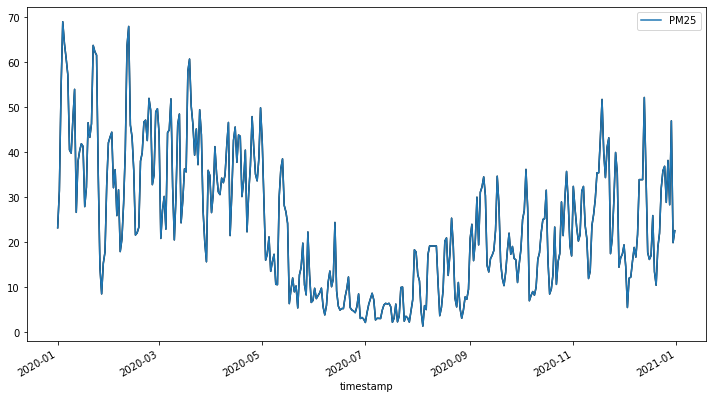

In [ ]:

data = df_hour.loc['2020-01-01':'2021-01-30']
data = data.resample('D').mean()
data.ffill(inplace=True)
train_len = -30
train = data.iloc[:train_len]
test = data.iloc[train_len:]

trainData = TimeSeriesData(train.reset_index(), time_col_name='timestamp')
trainData.plot(cols=["PM25"])

### Forecst-prophet

In [ ]:
# Specify parameters
params = ProphetParams(seasonality_mode="additive")

# Create a model instance
m = ProphetModel(trainData, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=30, freq="H")
fcst

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,time,fcst,fcst_lower,fcst_upper
0,2020-12-31 01:00:00,29.160807,15.932861,41.924399
1,2020-12-31 02:00:00,29.235766,16.528950,42.812784
2,2020-12-31 03:00:00,29.311061,15.931382,42.669881
3,2020-12-31 04:00:00,29.386330,15.923112,41.799811
4,2020-12-31 05:00:00,29.461199,15.339525,42.027071
5,2020-12-31 06:00:00,29.535287,16.315748,43.373023
6,2020-12-31 07:00:00,29.608205,16.214725,42.834355
7,2020-12-31 08:00:00,29.679565,15.960038,42.692159
8,2020-12-31 09:00:00,29.748977,15.378648,43.122331
9,2020-12-31 10:00:00,29.816057,17.657601,44.001746


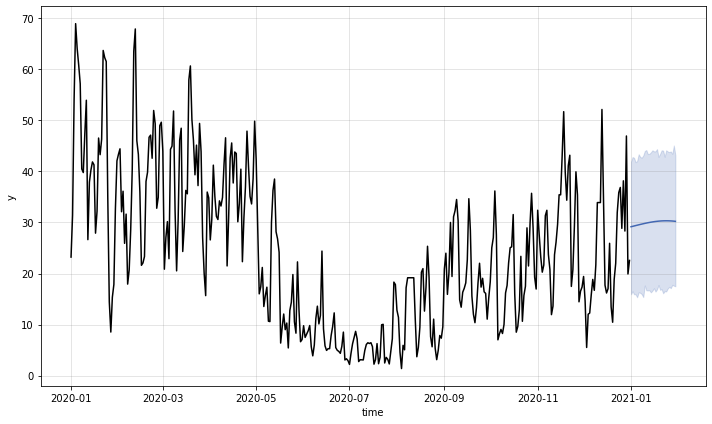

In [ ]:
m.plot()

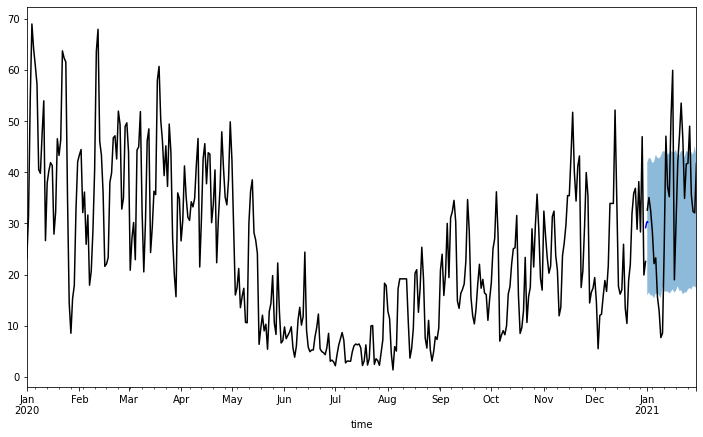

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label='train', color='black')
test.plot(ax=ax, color='black')
fcst.plot(x='time', y='fcst', ax=ax, color='blue')

ax.fill_between(test.index, fcst['fcst_lower'], fcst['fcst_upper'], alpha=0.5)
ax.get_legend().remove()

### Forecast-holt_winters

In [ ]:
warnings.simplefilter(action='ignore')

params = HoltWintersParams(
            trend="add",
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=trainData, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha=0.5, freq='H')
m.plot()

NameError: ignored

In [ ]:
fcst

,time,fcst,fcst_lower,fcst_upper
138,2021-08-03 17:00:00,217.342814,217.342814,217.342814
139,2021-08-04 17:00:00,218.576599,218.576599,218.576599
140,2021-08-05 17:00:00,219.413037,219.413037,219.413037
141,2021-08-06 17:00:00,259.772866,259.772866,259.772866
142,2021-08-07 17:00:00,292.290611,292.290611,292.290611
143,2021-08-08 17:00:00,263.360639,263.360639,263.360639
144,2021-08-09 17:00:00,237.364340,237.364340,237.364340
145,2021-08-10 17:00:00,275.626155,275.626155,275.626155
146,2021-08-11 17:00:00,307.545061,307.545061,307.545061
147,2021-08-12 17:00:00,312.203361,312.203361,312.203361


NameError: ignored

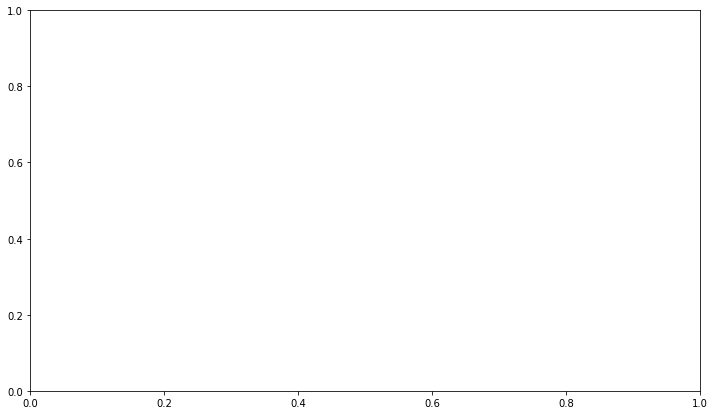

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label='train', color='black')
test.plot(ax=ax, color='black')
fcst.plot(x='time', y='fcst', ax=ax, color='blue')

ax.fill_between(test.index, fcst['fcst_lower'], fcst['fcst_upper'], alpha=0.5)
ax.get_legend().remove()

### ARIMA

### Preprocess

In [ ]:
Data = df.loc['2021-03-01':'2021-03-31']
Data.ffill(inplace=True)
Data = Data.rolling(window=10, min_periods=1).mean()
trainlen = -24
trainData = Data[:trainlen]
testData = Data[trainlen:]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
trainData_diff = trainData.diff()
trainData_diff = trainData_diff.dropna()

# Run Dicky-Fuller test
result = adfuller(trainData_diff)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -6.410030594302556
The p-value: 1.9008894702704797e-08


### Choose parameter

#### ACF

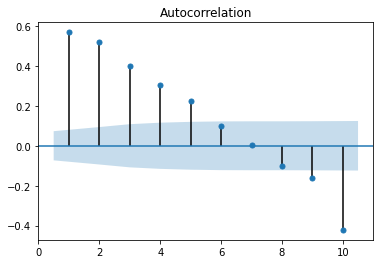

In [ ]:
# Make ACF plot
plot_acf(trainData_diff['PM25'], lags=10, zero=False)
plt.show()

#### PACF

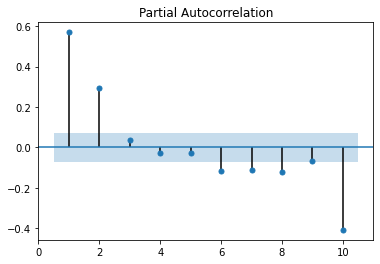

In [ ]:
# Make PACF plot
plot_pacf(trainData_diff['PM25'], lags=10, zero=False)
plt.show()

#### AIC & BIC

In [ ]:
order_aic_bic =[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(trainData['PM25'], order=(p, 1, q))
            results = model.fit()
            
            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

# lets sort them by AIC and BIC

# Sort by AIC
print("Sorted by AIC ")
# print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
# print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorted by AIC 
   p  q          aic          bic
0  2  2  3609.676237  3632.565543
1  2  0  3657.427879  3671.161463
2  1  2  3657.480121  3675.791567
3  2  1  3658.664046  3676.975492
4  1  1  3666.975582  3680.709166
5  1  0  3719.355939  3728.511662
6  0  2  3736.604836  3750.338421
7  0  1  3839.382915  3848.538638
8  0  0  3998.163225  4002.741086
Sorted by BIC 
   p  q          aic          bic
0  2  2  3609.676237  3632.565543
1  2  0  3657.427879  3671.161463
2  1  2  3657.480121  3675.791567
3  2  1  3658.664046  3676.975492
4  1  1  3666.975582  3680.709166
5  1  0  3719.355939  3728.511662
6  0  2  3736.604836  3750.338421
7  0  1  3839.382915  3848.538638
8  0  0  3998.163225  4002.741086


                               SARIMAX Results                                
Dep. Variable:                   PM25   No. Observations:                  720
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1799.838
Date:                Fri, 15 Jul 2022   AIC                           3609.676
Time:                        07:55:10   BIC                           3632.566
Sample:                    03-01-2021   HQIC                          3618.513
                         - 03-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8513      0.021     90.091      0.000       1.811       1.892
ar.L2         -0.9152      0.019    -48.894      0.000      -0.952      -0.879
ma.L1         -1.5482      0.034    -45.733      0.0

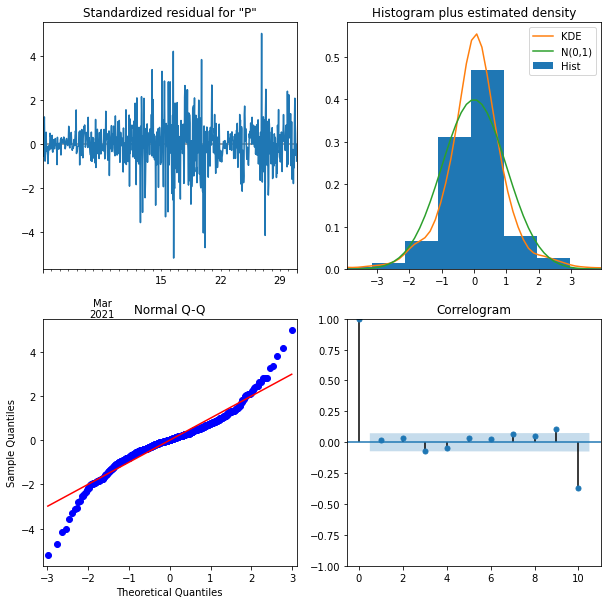

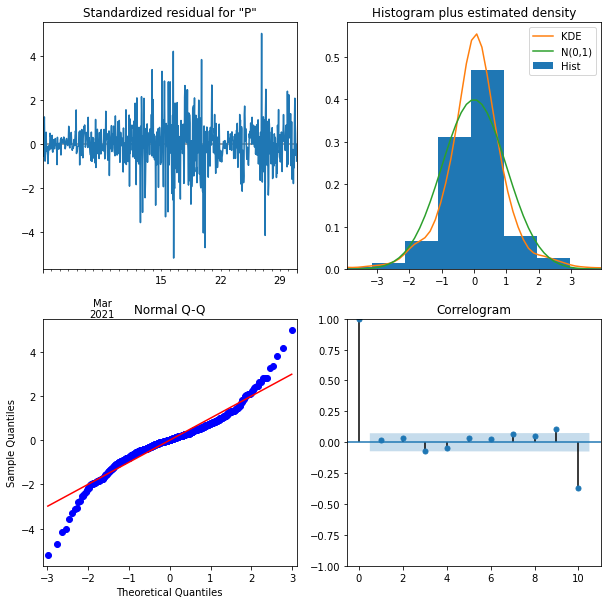

In [ ]:
# Instantiate model object
model = ARIMA(trainData, order=(2,1,2)) #2, 1, 2
# Fit model
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10, 10))

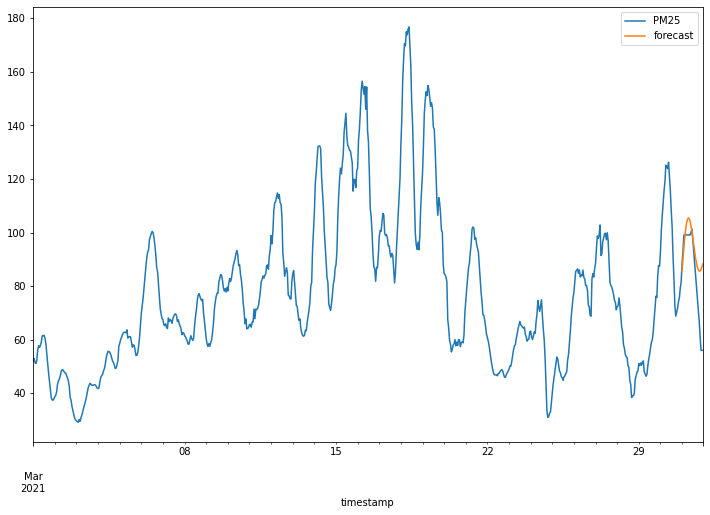

In [ ]:
Data['forecast'] = results.predict(start=720, end=743)
Data[['PM25', 'forecast']].plot(figsize=(12, 8))

### SARIMA & pmdarima

In [ ]:
Data = df.loc['2021-03-01':'2021-03-31']
Data.ffill(inplace=True)
Data = Data.rolling(window=10, min_periods=1).mean()
trainlen = -24
trainData = Data[:trainlen]
testData = Data[trainlen:]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:

trainData_diff = trainData.diff()
trainData_diff = trainData_diff.dropna()

# Run Dicky-Fuller test
result = adfuller(trainData_diff)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -6.410030594302556
The p-value: 1.9008894702704797e-08


                          PM25
timestamp                     
2021-03-30 00:00:00   7.178015
2021-03-30 01:00:00  10.327455
2021-03-30 02:00:00  11.361394
2021-03-30 03:00:00  11.346424
2021-03-30 04:00:00  10.301455
2021-03-30 05:00:00   8.461636
2021-03-30 06:00:00   9.733939
2021-03-30 07:00:00   5.600909
2021-03-30 08:00:00   2.213288
2021-03-30 09:00:00   2.435667
2021-03-30 10:00:00  -3.219833
2021-03-30 11:00:00  -6.679143
2021-03-30 12:00:00 -10.907524
2021-03-30 13:00:00 -12.644571
2021-03-30 14:00:00 -16.560508
2021-03-30 15:00:00 -17.172000
2021-03-30 16:00:00 -18.582778
2021-03-30 17:00:00 -14.616667
2021-03-30 18:00:00  -6.899444
2021-03-30 19:00:00  -1.530000
2021-03-30 20:00:00   2.682222
2021-03-30 21:00:00   3.569365
2021-03-30 22:00:00   5.133079
2021-03-30 23:00:00   5.093460


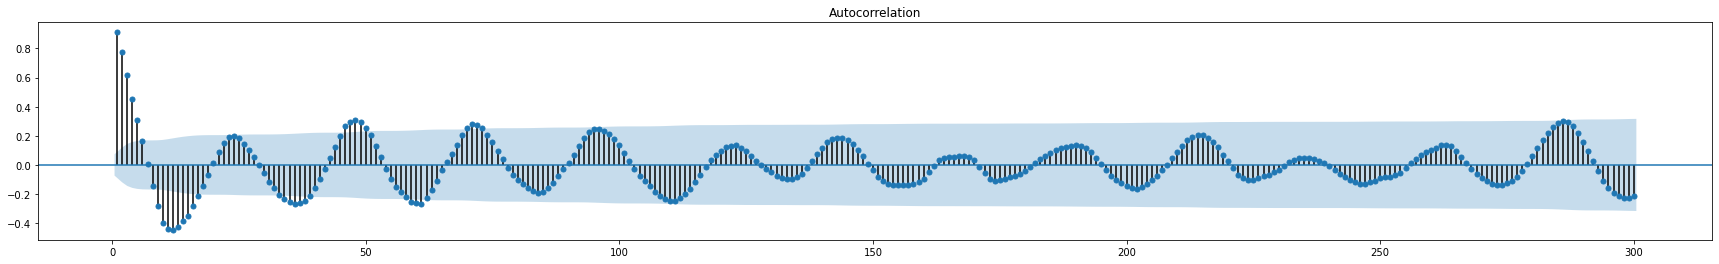

In [ ]:
# Subtract long rolling average over 5 steps
trainData = trainData - trainData.rolling(5).mean()
# Drop NaN values
trainData = trainData.dropna()
print(trainData[-24:])

# Identifying seasonal data using ACF

# Create figure
fig, ax = plt.subplots(1,1, figsize=(30,4))
# Plot ACF
plot_acf(trainData.dropna(), ax=ax, lags=300, zero=False)
plt.show()

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.6 MB/s eta 0:00:00


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1799.838
Date:                Mon, 18 Jul 2022   AIC                           3609.676
Time:                        04:57:05   BIC                           3632.566
Sample:                             0   HQIC                          3618.513
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8513      0.021     90.091      0.000       1.811       1.892
ar.L2         -0.9152      0.019    -48.894      0.000      -0.952      -0.879
ma.L1         -1.5482      0.034    -45.733      0.0

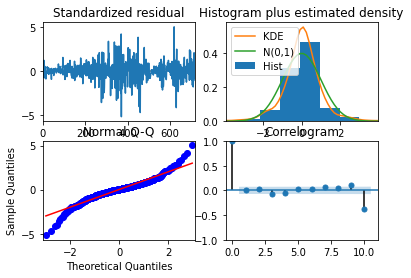

In [ ]:
results = pm.auto_arima(trainData)
print(results.summary())
results.plot_diagnostics()
print(results)

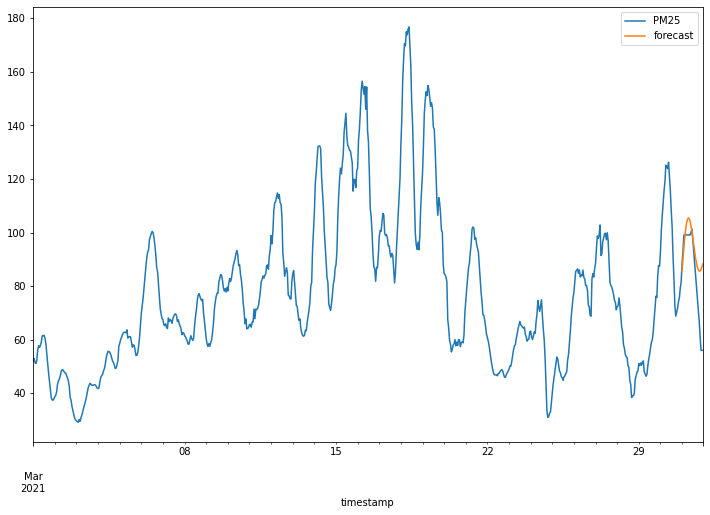

In [ ]:
Data['forecast'] = pd.DataFrame(results.predict(n_periods=24), index=testData.index)
# prediction
Data[['PM25', 'forecast']].plot(figsize=(12, 8))

### Holt Winter and Moving Averages

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/usr/

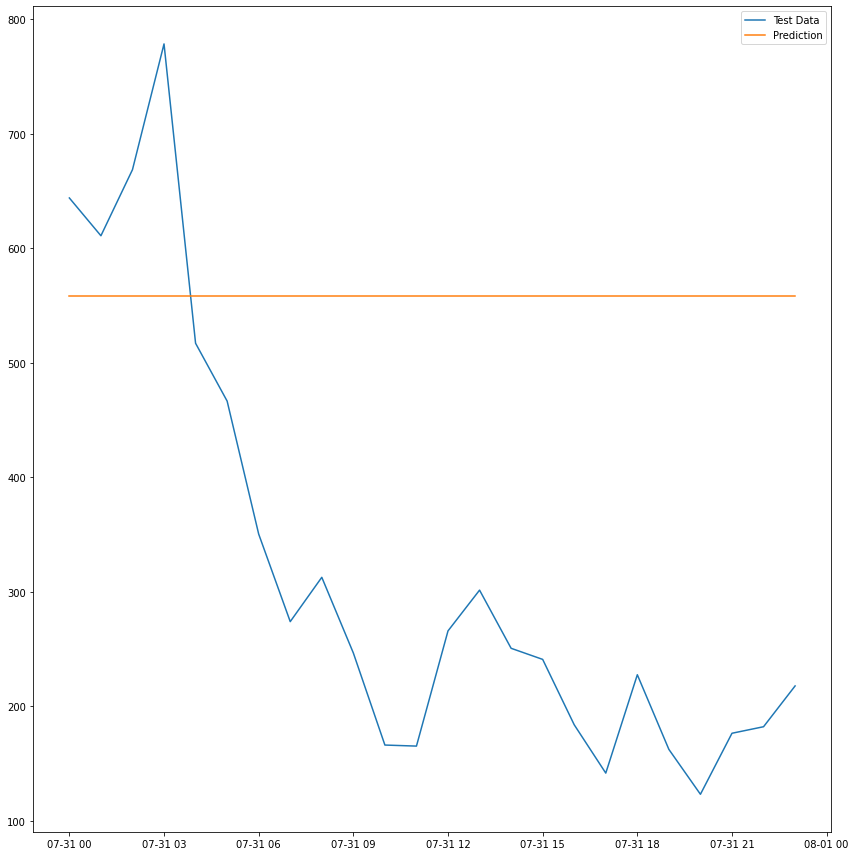

In [ ]:
data = df.loc['2021-07-02':'2021-07-31']
data.ffill(inplace=True)
trainData = data[:-24]
testData = data[-24:]
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
model_simp=SimpleExpSmoothing(trainData.PM25)
span = 24
alpha = 2/(span+1)
result_simp = model_simp.fit(smoothing_level=alpha, optimized=False)
n = result_simp.fittedvalues.shift(-1)
trainData['Simple_wgt_ma'] = n
testData['Simple_wgt_ma'] = result_simp.forecast(steps=len(testData))
plt.figure(figsize=(12, 12))
# plt.plot(trainData.PM25, label='Train Data')
# plt.plot(trainData.Simple_wgt_ma, label='Simple')
plt.plot(testData.PM25, label='Test Data')
plt.plot(testData.Simple_wgt_ma, label='Prediction')
plt.legend()
plt.tight_layout()

In [ ]:
data

,PM25
timestamp,
2021-05-02 00:00:00,42.000000
2021-05-02 01:00:00,42.000000
2021-05-02 02:00:00,77.000000
2021-05-02 03:00:00,77.000000
2021-05-02 04:00:00,40.000000
...,...
2021-05-31 19:00:00,25.900000
2021-05-31 20:00:00,17.454545
2021-05-31 21:00:00,17.600000


In [ ]:
trainData

,PM25,Simple_wgt_ma
timestamp,,
2021-05-02 00:00:00,42.000000,42.000000
2021-05-02 01:00:00,42.000000,42.000000
2021-05-02 02:00:00,77.000000,44.800000
2021-05-02 03:00:00,77.000000,47.376000
2021-05-02 04:00:00,40.000000,46.785920
...,...,...
2021-05-30 19:00:00,2.800000,10.142347
2021-05-30 20:00:00,11.909091,10.283687
2021-05-30 21:00:00,4.600000,9.828992


In [ ]:
testData

,PM25,Simple_wgt_ma
timestamp,,
2021-05-31 00:00:00,14.100000,10.937178
2021-05-31 01:00:00,20.363636,10.937178
2021-05-31 02:00:00,35.200000,10.937178
2021-05-31 03:00:00,15.100000,10.937178
2021-05-31 04:00:00,24.272727,10.937178
2021-05-31 05:00:00,35.500000,10.937178
2021-05-31 06:00:00,25.900000,10.937178
2021-05-31 07:00:00,34.500000,10.937178
2021-05-31 08:00:00,33.727273,10.937178
